In [1]:
from influxdb import InfluxDBClient
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')
from pandas import read_csv
from http.server import BaseHTTPRequestHandler, HTTPServer
import socketserver
import pickle
import urllib.request
import json
from pprint import pprint
from pandas.io.json import json_normalize
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from math import sqrt
import os
import errno
from pymongo import MongoClient
import urllib.parse as urlparse
from influxdb import InfluxDBClient
from pymongo import MongoClient
import pandas as pd
from pandas.io.json import json_normalize

In [2]:
folderNames = [
              's4t1rc1nc1t2xlargemixmixalapp1003e4'
               
              ]

host = '141.40.254.24'
port = 8086
username= 'root'
password = 'root'
appNames  = ["mixalapp"]


In [30]:
class Terminus():
    def getAllNodeNames(self,client):
        queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY=nodename;")
        nodeNames_temp = list(queryResult.get_points())
        dfnodeNames = pd.DataFrame(nodeNames_temp)
        allNodeNames = dfnodeNames[:]["value"]
        return allNodeNames
    def getNamespaceNames(self,client,node):
        nsQuery = client.query("SHOW TAG VALUES FROM uptime WITH KEY=namespace_name WHERE nodename = '"+node+"';")
        nsQuery_temp = list(nsQuery.get_points())
        dfnsNames = pd.DataFrame(nsQuery_temp)
        allnsNames = dfnsNames[:]["value"]
        return allnsNames
    def getAllPodNames(self,client,node,ns_name):
        queryResult = client.query("SHOW TAG VALUES FROM uptime WITH KEY = pod_name WHERE namespace_name = '"+ns_name+"' AND nodename = '"+node+"';")
        podNames_temp = list(queryResult.get_points())
        dfpodNames = pd.DataFrame(podNames_temp)
        if dfpodNames.empty: 
            return dfpodNames
        else:
            allpodNames = dfpodNames[:]["value"]
            return allpodNames
    def getCPUUtilizationNode(self,client, node):
        queryResult = client.query('SELECT * FROM "cpu/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
        dfcpuUtilization = pd.DataFrame(queryResult['cpu/node_utilization'])
        return dfcpuUtilization
    def getCPUUtilizationPod(self,client, node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
        return dfcpuUtilization
    def getCPUUtilizationPodContainer(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "cpu/usage_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
        dfcpuUtilization = pd.DataFrame(queryResult['cpu/usage_rate'])
        return dfcpuUtilization
    def prepareCpuUtilization(self,client,node,ns_name, pod_name):
        cpuUtilization = self.getCPUUtilizationNode(client,node)
        podCpuUtilization = self.getCPUUtilizationPod(client,node,ns_name, pod_name)
        containercpuUtilization = self.getCPUUtilizationPodContainer(client,node,ns_name, pod_name)
        plt.plot(cpuUtilization.index, cpuUtilization['value'] *1000, 'r', label="node") # plotting t, a separately 
        plt.plot(podCpuUtilization.index, podCpuUtilization['value'], 'b', label="pod") # plotting t, b separately 
        plt.plot(containercpuUtilization.index, containercpuUtilization['value'], 'g', label="container") # plotting t, c separately
        plt.legend(loc='upper left')
        plt.show()
    def getMemoryUtilizationNode(self,client,node):
        queryResult = client.query('SELECT * FROM "memory/node_utilization" where nodename = \''+node+'\' AND type=\'node\';')
        dfmemUtilization = pd.DataFrame(queryResult['memory/node_utilization'])
        return dfmemUtilization
    def getMemoryUtilizationPod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
        return dfmemUtilization
    def getMemoryUtilizationPodContainer(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "memory/usage" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\' AND type=\'pod_container\';')
        dfmemUtilization = pd.DataFrame(queryResult['memory/usage'])
        return dfmemUtilization
    def prepareMemoryUtilization(self,client,node,ns_name, pod_name):
        memoryUtilization = self.getMemoryUtilizationNode(client,node)
        podMemoryUtilization = self.getMemoryUtilizationPod(client,node,ns_name, pod_name)
        containerMemoryUtilization = self.getMemoryUtilizationPodContainer(client,node,ns_name, pod_name)
        plt.plot(memoryUtilization.index, memoryUtilization['value'], 'r', label="node") # plotting t, a separately 
        plt.plot(podMemoryUtilization.index, podMemoryUtilization['value'], 'b', label="pod") # plotting t, b separately 
        plt.plot(containerMemoryUtilization.index, containerMemoryUtilization['value'], 'g', label="container") # plotting t, c separately 
        plt.legend(loc='upper left')
        plt.show()
    def getNetworkTxRatePod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/tx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/tx_rate'])
        return dfmemUtilization
    def getNetworkTxPod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/tx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/tx'])
        return dfmemUtilization
    def getNetworkTxErrorsPod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/tx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors'])
        return dfmemUtilization
    def getNetworkTxErrorsRatePod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/tx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/tx_errors_rate'])
        return dfmemUtilization
    def prepareNetworkTxRateUtilization(self,client,node,ns_name, pod_name):
        podNetworTxRate = self.getNetworkTxRatePod(client,node,ns_name, pod_name)
        podNetworTx = self.getNetworkTxPod(client,node,ns_name, pod_name)
        podNetworkError = self.getNetworkTxErrorsPod(client,node,ns_name, pod_name)
        podNetworkErrorRate = self.getNetworkTxErrorsRatePod(client,node,ns_name, pod_name)
        plt.plot(podNetworTxRate.index, podNetworTxRate['value'], 'b') # plotting t, b separately 
        #plt.plot(podNetworTx.index, podNetworTx['value'], 'g') # plotting t, b separately 
        #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately 
        plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately 
        plt.show()
    def getNetworkRxRatePod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/rx_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/rx_rate'])
        return dfmemUtilization
    def getNetworkRxPod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/rx" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/rx'])
        return dfmemUtilization

    def getNetworkRxErrorsPod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/rx_errors" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors'])
        return dfmemUtilization
    def getNetworkRxErrorsRatePod(self,client,node,ns_name, pod_name):
        queryResult = client.query('SELECT * FROM "network/rx_errors_rate" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\';')
        dfmemUtilization = pd.DataFrame(queryResult['network/rx_errors_rate'])
        return dfmemUtilization
    def prepareNetworkRxRateUtilization(self,client,node,ns_name, pod_name):
        podNetworRxRate = self.getNetworkRxRatePod(client,node,ns_name, pod_name)
        podNetworRx = self.getNetworkRxPod(client,node,ns_name, pod_name)
        podNetworkError = self.getNetworkRxErrorsPod(client,node,ns_name, pod_name)
        podNetworkErrorRate = self.getNetworkRxErrorsRatePod(client,node,ns_name, pod_name)
        plt.plot(podNetworRxRate.index, podNetworRxRate['value'], 'b') # plotting t, b separately 
        #plt.plot(podNetworRx.index, podNetworRx['value'], 'g') # plotting t, b separately 
        #plt.plot(podNetworkError.index, podNetworkError['value'], 'y') # plotting t, b separately 
        plt.plot(podNetworkErrorRate.index, podNetworkErrorRate['value'], 'r') # plotting t, b separately 
        plt.show()
    def getRelevantNodeName(self,client,ns_name):
        allNodeNames  = self.getAllNodeNames(client)
        #nsNames = getNamespaceNames(allNodeNames[0])
        for node in allNodeNames:
            allPodNamesNode = self.getAllPodNames(client,node,ns_name)
            if(not allPodNamesNode.empty):
                return node

    def getNodeResourceUtilizationDf(self,client, nodeName):
        Result_node_CPU = client.query("SELECT value from \"cpu/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")
        Result_node_MEM = client.query("SELECT value from \"memory/node_utilization\" where nodename = '"+nodeName+"' AND type = 'node' ")

        Result_node_CPU_Cores = client.query("SELECT mean(\"value\") FROM \"cpu/node_capacity\" where nodename = '"+nodeName+
                                             "' AND type = 'node' GROUP BY time(1m)")
        Result_node_mem_node = client.query("SELECT mean(\"value\")FROM \"memory/node_capacity\" where nodename = '"+
                                            nodeName+"' AND type = 'node' GROUP BY time(1m)")

        cpu_points = pd.DataFrame(Result_node_CPU.get_points())
        cpu_points['time'] = pd.to_datetime(cpu_points['time'])
        cpu_points = cpu_points.set_index('time')
        cpu_points.columns = ['node_cpu_util']
        mem_points = pd.DataFrame(Result_node_MEM.get_points())
        mem_points['time'] = pd.to_datetime(mem_points['time'])
        mem_points = mem_points.set_index('time')
        mem_points.columns = ['node_mem_util']

        cores_points = pd.DataFrame(Result_node_CPU_Cores.get_points())
        cores_points['time'] = pd.to_datetime(cores_points['time'])
        cores_points = cores_points.set_index('time')
        cores_points.columns = ['node_cores']

        mem_node_points = pd.DataFrame(Result_node_mem_node.get_points())
        mem_node_points['time'] = pd.to_datetime(mem_node_points['time'])
        mem_node_points = mem_node_points.set_index('time')
        mem_node_points.columns = ['node_mem']

        df_node =pd.concat([cpu_points, mem_points,cores_points,mem_node_points], axis=1)
        return df_node
    def getPodResourceUtilizationDf(self,client, node, ns_name, pod_name):
        Result_Pod_CPU_usage = client.query('SELECT value FROM "cpu/usage_rate" where nodename = \''+node+
                                            '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                            '\'  AND type=\'pod\';')
        Result_Pod_MEM_usage = client.query('SELECT value from \"memory/usage\" where nodename = \''+node+
                                            '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                            '\'  AND type=\'pod\';')

        Result_Pod_CPU_limit = client.query('SELECT mean(\"value\") FROM "cpu/limit" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
        Result_Pod_MEM_limit = client.query('SELECT mean(\"value\") from \"memory/limit\" where nodename = \''+node+
                                            '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                            '\'  AND type=\'pod\' group by time(1m);')

        Result_Pod_CPU_requests = client.query('SELECT mean(\"value\") FROM "cpu/request" where nodename = \''+node+'\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+'\'  AND type=\'pod\' group by time(1m);')
        Result_Pod_MEM_requests = client.query('SELECT mean(\"value\") from \"memory/request\" where nodename = \''+node+
                                               '\' AND pod_name = \''+pod_name+'\' AND namespace_name = \''+ns_name+
                                               '\'  AND type=\'pod\' group by time(1m);')


        cpu_points_usage = pd.DataFrame(Result_Pod_CPU_usage.get_points())
        cpu_points_usage['time'] = pd.to_datetime(cpu_points_usage['time'])
        cpu_points_usage = cpu_points_usage.set_index('time')
        cpu_points_usage.columns = ['pod_cpu_usage']


        mem_points_usage = pd.DataFrame(Result_Pod_MEM_usage.get_points())
        mem_points_usage['time'] = pd.to_datetime(mem_points_usage['time'])
        mem_points_usage = mem_points_usage.set_index('time')
        mem_points_usage.columns = ['pod_mem_usage']


        cpu_points_limits = pd.DataFrame(Result_Pod_CPU_limit.get_points())
        cpu_points_limits['time'] = pd.to_datetime(cpu_points_limits['time'])
        cpu_points_limits = cpu_points_limits.set_index('time')
        cpu_points_limits.columns = ['pod_cpu_limit']


        mem_points_limits = pd.DataFrame(Result_Pod_MEM_limit.get_points())
        mem_points_limits['time'] = pd.to_datetime(mem_points_limits['time'])
        mem_points_limits = mem_points_limits.set_index('time')
        mem_points_limits.columns = ['pod_mem_limit']


        cpu_points_request = pd.DataFrame(Result_Pod_CPU_requests.get_points())
        cpu_points_request['time'] = pd.to_datetime(cpu_points_request['time'])
        cpu_points_request = cpu_points_request.set_index('time')
        cpu_points_request.columns = ['pod_cpu_request']


        mem_points_request = pd.DataFrame(Result_Pod_MEM_requests.get_points())
        mem_points_request['time'] = pd.to_datetime(mem_points_request['time'])
        mem_points_request = mem_points_request.set_index('time')
        mem_points_request.columns = ['pod_mem_request']

        df_pod =pd.concat([cpu_points_usage, mem_points_usage,cpu_points_limits,mem_points_limits,cpu_points_request,mem_points_request ], axis=1)

        return df_pod
    def getRequestsDf(self,clientK6):
        queryResult = clientK6.query('SELECT sum("value") FROM "vus" group by time(1m);')
        vus = pd.DataFrame(queryResult['vus'])
        vus.columns = ['vus','time']
        vus = vus.set_index('time')


        queryResultReqs = clientK6.query('SELECT sum("value") FROM "http_reqs" group by time(1m);')
        reqs = pd.DataFrame(queryResultReqs['http_reqs'])
        reqs.columns = ['requests','time']
        reqs = reqs.set_index('time')
        queryResultReqsDuration95 = clientK6.query('SELECT percentile("value", 95) FROM "http_req_duration" group by time(1m) ;')
        reqs_duration95 = pd.DataFrame(queryResultReqsDuration95['http_req_duration'])
        reqs_duration95.columns = [ 'requests_duration_percentile_95','time']
        reqs_duration95 = reqs_duration95.set_index('time')
        queryResultReqsDuration90 = clientK6.query('SELECT percentile("value", 90) FROM "http_req_duration" group by time(1m) ;')
        reqs_duration90 = pd.DataFrame(queryResultReqsDuration90['http_req_duration'])
        reqs_duration90.columns = ['requests_duration_percentile_90','time']
        reqs_duration90 = reqs_duration90.set_index('time')

        queryResultMaxDuration = clientK6.query('SELECT max("value") FROM "http_req_duration" group by time(1m);')
        reqs_duration_max = pd.DataFrame(queryResultMaxDuration['http_req_duration'])
        reqs_duration_max.columns = ['requests_duration_max','time']
        reqs_duration_max = reqs_duration_max.set_index('time')

        queryResultMinDuration = clientK6.query('SELECT min("value") FROM "http_req_duration" group by time(1m);')
        reqs_duration_min = pd.DataFrame(queryResultMinDuration['http_req_duration'])
        reqs_duration_min.columns = ['requests_duration_min','time']
        reqs_duration_min = reqs_duration_min.set_index('time')

        queryResultMeanDuration = clientK6.query('SELECT mean("value") FROM "http_req_duration" group by time(1m);')
        reqs_duration_mean = pd.DataFrame(queryResultMeanDuration['http_req_duration'])
        reqs_duration_mean.columns = ['requests_duration_mean','time']
        reqs_duration_mean = reqs_duration_mean.set_index('time')

        queryResultMedianDuration = clientK6.query('SELECT median("value") FROM "http_req_duration" group by time(1m);')
        reqs_duration_median = pd.DataFrame(queryResultMedianDuration['http_req_duration'])
        reqs_duration_median.columns = ['requests_duration_median','time']
        reqs_duration_median = reqs_duration_median.set_index('time')

        finalDF = pd.merge(vus, reqs, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF, reqs_duration95, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF, reqs_duration90, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF,reqs_duration_max, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF,reqs_duration_min, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF,reqs_duration_mean, left_index=True, right_index=True)
        finalDF = pd.merge(finalDF,reqs_duration_median, left_index=True, right_index=True)
        finalDF.index = pd.to_datetime(finalDF.index)

        return finalDF

    def getPodsNodesRequestsDf(self,appNames, client,  clientK6):
        default_ns_name =  "default"
        relevantNodeName = self.getRelevantNodeName(client,default_ns_name)
        podNames = self.getAllPodNames(client,relevantNodeName, default_ns_name)
        df_node = self.getNodeResourceUtilizationDf(client,relevantNodeName)
        df_pods_node = []
        for podName in podNames: 
            if "mongo" not in podName: 
                df_pod = self.getPodResourceUtilizationDf(client,relevantNodeName, default_ns_name, podName)
                finalDF = pd.merge(df_node,df_pod, left_index=True, right_index=True)
                requestsDF = self.getRequestsDf(clientK6)
                finalDF = pd.merge(finalDF,requestsDF, left_index=True, right_index=True)
                finalDF['pod_name'] = podName          
                if(finalDF['pod_cpu_limit'].values[0]==0):
                    finalDF['pod_cpu_usage'] = finalDF['pod_cpu_usage']/(finalDF['node_cores'])
                    finalDF['pod_cpu_limit'] = finalDF['node_cores']/1000
                    finalDF['pod_cpu_request'] = finalDF['node_cores']/1000
                else:  
                    finalDF['pod_cpu_usage'] = finalDF['pod_cpu_usage']/(finalDF['pod_cpu_limit'])
                    finalDF['pod_cpu_limit'] = finalDF['pod_cpu_limit']/1000
                    finalDF['pod_cpu_request'] = finalDF['pod_cpu_request']/1000
                    
                if(finalDF['pod_mem_limit'].values[0]==0):   
                    finalDF['pod_mem_usage'] = finalDF['pod_mem_usage']/(finalDF['node_mem'])
                    finalDF['pod_mem_limit'] = finalDF['node_mem']/(1073741824)
                    finalDF['pod_mem_request'] = finalDF['node_mem']/(1073741824)
                else:
                    finalDF['pod_mem_usage'] = finalDF['pod_mem_usage']/(finalDF['pod_mem_limit'])
                    finalDF['pod_mem_limit'] = finalDF['pod_mem_limit']/(1073741824)
                    finalDF['pod_mem_request'] = finalDF['pod_mem_request']/(1073741824)

                finalDF['node_cores'] = finalDF['node_cores']/1000
                finalDF['node_mem'] = finalDF['node_mem']/(1073741824)

                finalDF = finalDF.fillna(0)
                finalDF = finalDF[(finalDF.T != 0).any()]
                df_pods_node.append(finalDF)
        return df_pods_node
    
    def getAndCombineAllDbs(self, host, port, username, password,appNames, folderNames):
        allFinalDFs = []
        for folderName in folderNames:
            client = InfluxDBClient(host, port,username , password, folderName+'_k8s')
            clientK6 = InfluxDBClient(host, port, username, password, folderName+'_TestK6')
            df_pods_node = self.getPodsNodesRequestsDf(appNames, client, clientK6)
            print(folderName)
            finalDF = pd.DataFrame()
            finalDF['pod_util_cpu_sum'] = 0
            finalDF['pod_util_mem_sum'] = 0
            first = 1
            allDfPods = pd.DataFrame()
            for i in range(len(df_pods_node)):
                df_pods_node[i] = df_pods_node[i].reset_index(drop=True)
                allDfPods = allDfPods.append(df_pods_node[i])

            finalDF = pd.concat([finalDF, allDfPods[['node_cores', 'node_mem','node_cpu_util','node_mem_util', 'pod_cpu_limit', 'pod_cpu_request','pod_mem_limit',
                                               'pod_mem_request','vus','requests','requests_duration_percentile_95',
                                              'requests_duration_percentile_90','requests_duration_max', 'requests_duration_min',
                                               'requests_duration_mean', 'requests_duration_median', 'pod_name'
                                              ]]], axis=1)

            for i in range(len(df_pods_node)):
                    df_pods_node[i] = df_pods_node[i].reset_index(drop=True)
                    if(first==1):
                        finalDF['pod_util_cpu_sum'] = df_pods_node[i]['pod_cpu_usage']
                        finalDF['pod_util_mem_sum'] = df_pods_node[i]['pod_mem_usage']
                        first=0
                    else:
                        finalDF['pod_util_cpu_sum'] = finalDF['pod_util_cpu_sum'] +  df_pods_node[i]['pod_cpu_usage']
                        finalDF['pod_util_mem_sum'] = finalDF['pod_util_mem_sum'] +  df_pods_node[i]['pod_mem_usage']

                finalDF['num_pods'] = int(len(df_pods_node))
                finalDF['pod_util_cpu_avg'] = finalDF['pod_util_cpu_sum']/finalDF['num_pods']
                finalDF['pod_util_mem_avg'] = finalDF['pod_util_mem_sum']/finalDF['num_pods']

                finalDF = pd.concat([finalDF, df_pods_node[0][['node_cores', 'node_mem','node_cpu_util','node_mem_util', 'pod_cpu_limit', 'pod_cpu_request','pod_mem_limit',
                                                               'pod_mem_request','vus','requests','requests_duration_percentile_95',
                                                              'requests_duration_percentile_90','requests_duration_max', 'requests_duration_min',
                                                               'requests_duration_mean', 'requests_duration_median'
                                                              ]]], axis=1)
            allFinalDFs.append(finalDF)
        df = pd.DataFrame()
        for idx in range(len(folderNames)):
            df = df.append(allFinalDFs[idx])
            
        final_df  = df[['requests','requests_duration_mean','pod_cpu_limit','node_cores', 'node_mem','pod_mem_limit',
                        'pod_name'
                        ]]
        #final_df['pod_util_cpu_avg'] = final_df['pod_util_cpu_avg']*final_df['pod_cpu_limit']
        #final_df['pod_util_mem_avg'] = final_df['pod_util_mem_avg']*final_df['pod_mem_limit']
        #final_df = final_df.sort_values(['requests']) 
        #final_df = final_df[(final_df[['pod_util_cpu_avg','pod_util_mem_avg','requests_duration_mean']] != 0).all(axis=1)]
        #final_df = final_df[np.isfinite(final_df['requests'])]
        #final_df = final_df[np.isfinite(final_df['requests_duration_mean'])]
        #final_df = final_df[np.isfinite(final_df['pod_util_cpu_avg'])]
        #final_df = final_df[np.isfinite(final_df['pod_util_mem_avg'])]
        #final_df = final_df[final_df.requests_duration_mean < 2500]
        #final_df = final_df.reset_index(drop=True)
        return final_df


In [31]:
T= Terminus()

In [32]:
df = T.getAndCombineAllDbs(host, port, username, password,appNames, folderNames)

s4t1rc1nc1t2xlargemixmixalapp1003e4


In [34]:
df

,requests,requests_duration_mean,pod_cpu_limit,node_cores,node_mem,pod_mem_limit,pod_name
0,23.0,137.750435,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
1,82.0,93.363204,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
2,315.0,88.705648,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
3,349.0,1232.562816,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
4,105.0,1656.249169,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
5,160.0,2233.563888,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
6,58.0,2191.510519,0.0,4.0,15.674213,0.000000,movieapp-deployment-5hjpg
7,123.0,2975.642337,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
8,0.0,0.000000,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg
9,239.0,3466.231069,0.1,4.0,15.674213,0.097656,movieapp-deployment-5hjpg


In [384]:
df.to_csv('web_final.csv')
dataset = read_csv('primeapp_final.csv', header=0, index_col=0)

In [385]:
dataset = read_csv('web_final.csv', header=0, index_col=0)

In [386]:
dataset.head()

,requests,requests_duration_mean,num_pods,pod_cpu_limit,node_cores,node_mem,pod_mem_limit,pod_util_cpu_avg,pod_util_mem_avg
0,957.0,1.682847,1,1.0,1.0,0.971558,0.971558,0.001,0.018677
1,1904.0,1.419605,1,1.0,1.0,0.479385,0.479385,0.001,0.026237
2,1909.0,1.485496,1,2.0,2.0,3.861710,3.861710,0.001,0.016830
3,2180.0,1.448912,1,1.0,1.0,0.971558,0.971558,0.006,0.019211
4,2249.0,1.449115,1,1.0,1.0,1.955933,1.955933,0.001,0.016590


In [387]:
dataset = dataset.sort_values(['pod_util_cpu_avg'])

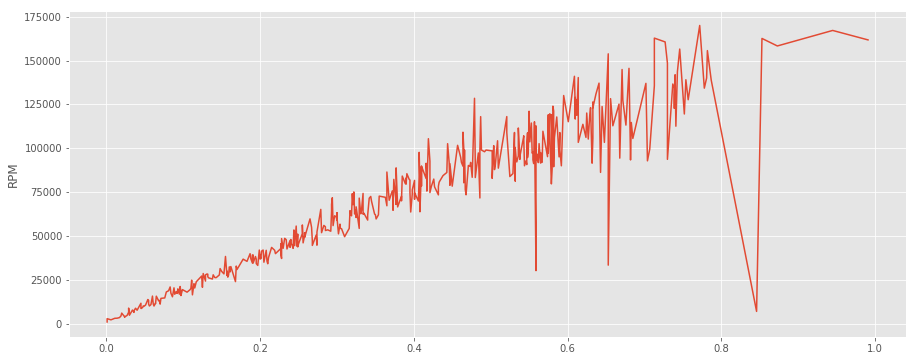

In [388]:
largeNum=0


plt.plot( dataset['pod_util_cpu_avg'], dataset['requests'])

plt.ylabel("RPM")

plt.grid(True)
plt.show()

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

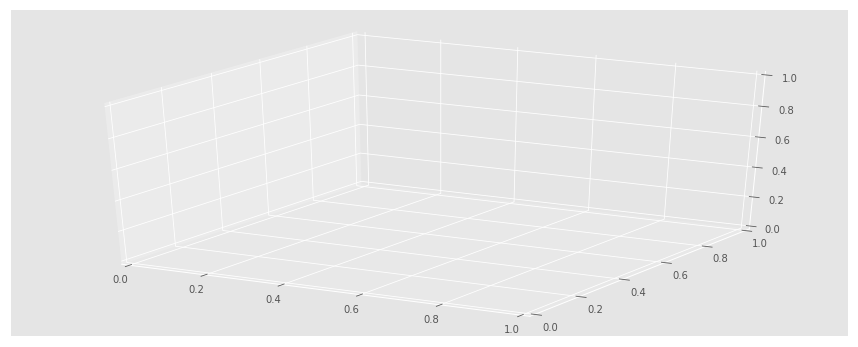

In [389]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(dataset['requests'], dataset['num_pods'], dataset['pod_util_cpu_avg'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(dataset['requests'], dataset['num_pods'], dataset['pod_util_cpu_avg'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(30, 45)
plt.show()
 
# Other palette
ax.plot_trisurf(dataset['requests'], dataset['num_pods'], dataset['pod_util_cpu_avg'], cmap=plt.cm.jet, linewidth=0.01)
plt.show()

In [390]:
dataset = dataset.fillna(0)

In [391]:
dftemp_cpu = dataset[['requests','num_pods',  'requests_duration_mean','node_cores', 'node_mem', 'pod_util_cpu_avg','pod_cpu_limit', 'pod_util_mem_avg', 'pod_mem_limit']]
#dftemp_mem = df[['requests', 'node_cores','node_mem', 'node_mem_util','pod_cpu_limit','pod_cpu_request','pod_mem_usage','pod_mem_limit','pod_mem_request', 'requests_duration_mean', 'requests_duration_percentile_95']]


In [428]:
df_X = dftemp_cpu[['pod_util_cpu_avg','pod_cpu_limit','pod_mem_limit', 'num_pods', 'requests_duration_mean']].values
df_Y = dftemp_cpu[['requests']].values
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33, random_state=42)

Degree=  8  RMS =  6875.407799299019
Degree=  2  RMS =  11542.574484136847
Degree=  1  RMS =  12217.87215201107


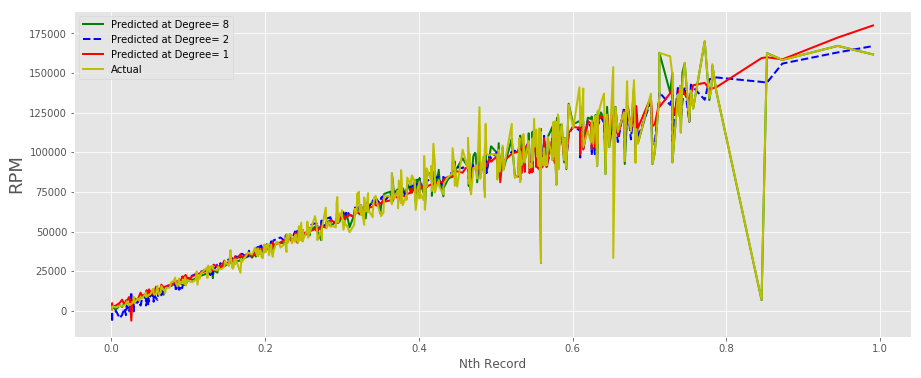

In [439]:
 for style, width, degree in (("g-", 2, 8), ("b--", 2, 2), ("r-", 2, 1)):
            polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
            std_scaler = StandardScaler()
            lin_reg = linear_model.LinearRegression()
            polynomial_regression = Pipeline([
                ("poly_features", polybig_features),
                ("std_scaler", std_scaler),
                ("lin_reg", lin_reg),
            ])
            polynomial_regression.fit(df_X, df_Y)
            y_newbig = polynomial_regression.predict(df_X)
            plt.plot(df_X[:,0], y_newbig, style, label="Predicted at Degree= "+str(degree), linewidth=width)
            rms = sqrt(mean_squared_error(df_Y, y_newbig))
            print("Degree= ", degree," RMS = ", rms)
plt.plot(df_X[:,0], df_Y, "y", linewidth=2, label="Actual")
plt.legend(loc="upper left")
plt.xlabel("Nth Record")
plt.ylabel("RPM", rotation=90, fontsize=18)
plt.show()


In [440]:
import seaborn as sb

# Linear Regression

In [441]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Create linear regression object
#model = linear_model.LinearRegression()
polybig_features = PolynomialFeatures(degree=2, include_bias=False)
std_scaler = StandardScaler()
lin_reg = linear_model.LinearRegression()
regr = Pipeline([
                ("poly_features", polybig_features),
                ("std_scaler", std_scaler),
                ("lin_reg", lin_reg),
            ])
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

rms = sqrt(mean_squared_error(y_test, y_pred))
print ('rms %.2f' % rms)
#print ('Test score %.2f', regr.score(X_test, y_test) )
#print ('Pred score %.2f', regr.score(X_test, y_pred) )

Mean squared error: 360894827.56
Variance score: 0.82
rms 18997.23


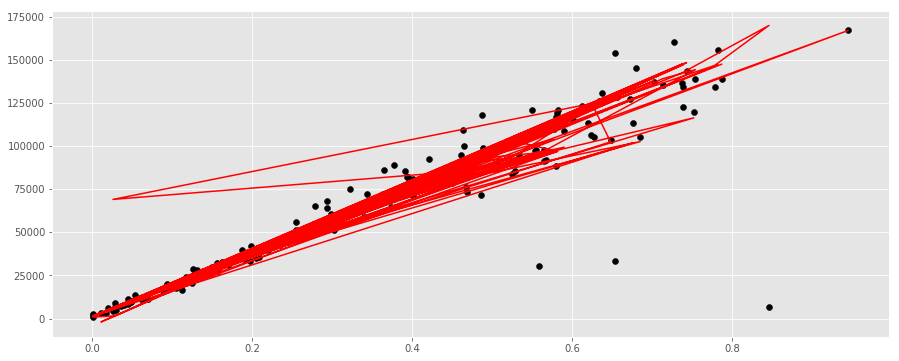

In [442]:
# Plot outputs
plt.scatter(X_test[:,0], y_test,  color='black')
#plt.plot(X_test[:,0], y_pred, color='blue')
plt.plot(X_test[:,0],y_pred,'-r')

plt.show()

In [349]:
regr.predict([[0.1,0.1,0.1,1,1000]])

array([[ 597.58459713]])